link to original notebook
*note: this notebook is missing a signifcant amount of code an will not run on it's own*
https://colab.research.google.com/github/idiap/w2v2-air-traffic/blob/main/src/eval_xlsr_atc_model.ipynb#scrollTo=7ddc6ef1-5a73-40c8-8199-deb3e94bdb2b

In [12]:
import os

from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCTC, Wav2Vec2Processor, AutoProcessor, pipeline
import torchaudio.functional as F

import re
from evaluate import load

if os.name == 'posix':
    # Linux
    os.chdir('/home/rodoggx/Documents/iResearch-2024/DATA')
elif os.name == 'nt':
    # Windows
    os.chdir('C:/Users/rowan/OneDrive/Desktop/code/iResearch-2024/DATA')
else:
    print("Unknown operating system")

In [3]:
audioFiles = [f for f in os.listdir() if f.endswith('.wav')]
xmlFiles = []
for i in range(len(audioFiles)):
	xmlFiles.append(audioFiles[i].replace('.wav', '.xml'))

transcripts = []

datasetDict = {
	'audio': audioFiles,
	'transcripts': []
}

for i in range(len(xmlFiles)):
	with open(xmlFiles[i], 'r', encoding='utf-8') as file:
		data = file.read()

	Bs_data = BeautifulSoup(data, "xml")
	b_unique = Bs_data.find_all('text')
	for j in b_unique:
		transcripts.append(j.text)
	datasetDict['transcripts'].append(transcripts)
	transcripts = []

df = pd.DataFrame(datasetDict)

df.to_csv('dataset.csv', index=False)

df


,audio,transcripts
0,LKPR_RUZYNE_Radar_120_520MHz_20201026_205056.wav,[KLM Seven Three Whiskey maintain present head...
1,LKPR_RUZYNE_Tower_134_560MHz_20201025_101021.wav,[Ryan Air Seven Romeo Mike route reaching and ...
2,LZIB_STEFANIK_Tower_118_3MHz_20210505_145115.wav,[Topjet Four Zero Two via delta foxtrot ten th...
3,LKTB_BRNO_Approach-Radar_127_350MHz_20201028_1...,[Oscar Kilo Delta Sierra India turn left headi...
4,LKPR_RUZYNE_Tower_134_560MHz_20201025_204809.wav,[Ruzyne tower Trans Europe Four Two One [Ne Cz...
...,...,...
555,YSSY_SYDNEY_Tower_120_5MHz_20210502_055020.wav,[[#unnamed]tower[/#unnamed] [#unnamed]good[/#u...
556,LSZH_ZURICH_Tower_118_1MHz_20210414_101150.wav,[Hotel Delta Lima contact apron one two one de...
557,YSSY_SYDNEY_Tower_120_5MHz_20210505_124859.wav,[[#command]cleared[/#command] [#command]to[/#c...
558,YSSY_SYDNEY_Tower_120_5MHz_20210501_090436.wav,[Sydney tower evening Qantas Seventy Seven Zer...


In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=False, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
sample = dataset[0]["audio"]

result = pipe(sample)
print(result["text"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\rowan\OneDrive\Desktop\code\iResearch-2024\venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel. Nor is Mr. Quilter's manner less interesting than his matter. He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind. He has grave doubts whether Sir Frederick Leighton's work is really Greek after all, and can discover in it but little of rocky Ithaca. Linnell's pictures are a sort of Upguards and Adam paintings, and Mason's exquisite idylls are as national as a jingo poem. Mr. Burkett Foster's landscapes smile at one much in the same way that Mr. Carker used to flash his teeth. And Mr. John Collier gives his sitter a cheerful slap on the back before he says, like a shampooer in a Turkish bath, Next man!


In [26]:
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim")

result = pipe(df['audio'][0])
print(result['text'])
print(df['transcripts'][0])

print(type(result['text']))
print(type(df['transcripts'][0]))

wer = load('wer')
wer_score = wer.compute(predictions=[result['text']], references=[df['transcripts'][0][0]])
print(wer_score)

Some weights of the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrization

lm seven three whiskey maintain present heading for vectoring ils approach runway two four and rehe our speed no below two six zero knots
['KLM Seven Three Whiskey maintain present heading for vectoring for ILS approach runway two four and reduce your speed now below two six zero knots']
<class 'str'>
<class 'list'>
0.36


In [21]:
modelsList = [
    'openai/whisper-large-v3',
    'Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim',
    'facebook/wav2vec2-base-960h'
]

resultsData = {
    'Model': modelsList,
    'Average WER': [],
    'Lowest WER': [],
    'Highest WER': [],
    'Values': []
}

wer= load('wer')

for model in modelsList:
    totalWER = 0
    itterations = 50
    lowWER = 1
    highWER = 0
    
    temp = []

    pipe = pipeline("automatic-speech-recognition", model=model)

    for i in range(itterations):
        result = pipe(df['audio'][i])
        transcription = ''

        for j in range(len(df['transcripts'][i])):
            transcription += df['transcripts'][i][j] + ' '

        if transcription.endswith(' '):
            transcription = transcription[:-1]

        transcription = re.sub(r'\[.*?\]', '', transcription)
        transcription = transcription.replace('[', '').replace(']', '')

        transcription = re.sub(r'\s+', ' ', transcription)

        wer_score = wer.compute(predictions=[result['text'].lower()], references=[transcription.lower()])
        temp.append(wer_score)
        print(wer_score)
        totalWER += wer_score
        if wer_score < lowWER:
            lowWER = wer_score
        if wer_score > highWER:
            highWER = wer_score

    averageWER = totalWER / itterations
    print(f"Average WER for {model}: {averageWER}")
    resultsData['Average WER'].append(averageWER)
    resultsData['Lowest WER'].append(lowWER)
    resultsData['Highest WER'].append(highWER)
    resultsData['Values'].append(temp)

resultsDf = pd.DataFrame.from_dict(resultsData, orient='columns')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7948717948717948


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9473684210526315


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.631578947368421


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.75


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6206896551724138


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9666666666666667


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5714285714285714


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7111111111111111


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8636363636363636


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9615384615384616


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9230769230769231


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6875


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.7272727272727273


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9142857142857143


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.88


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.4375


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.725


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.35714285714285715


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8888888888888888


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.09090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6363636363636364


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9090909090909091


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.2857142857142857


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6666666666666666


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.8275862068965517


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.34782608695652173


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.6


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.9285714285714286


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


1.0


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5652173913043478


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.42857142857142855


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5


/home/rodoggx/Documents/iResearch-2024/venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


0.5833333333333334
Average WER for openai/whisper-large-v3: 0.7089128266825105


Some weights of the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrization

0.2
0.5641025641025641
0.3157894736842105
0.23809523809523808
0.35135135135135137
0.3684210526315789
0.26666666666666666
0.13333333333333333
0.5
0.6666666666666666
1.0
0.41379310344827586
0.6333333333333333
0.5
0.42857142857142855
0.4444444444444444
0.36363636363636365
0.19230769230769232
0.07692307692307693
0.7
0.4375
0.5
0.7142857142857143
0.5
0.35294117647058826
0.47619047619047616
0.9166666666666666
0.52
0.40625
0.475
0.42857142857142855
0.6666666666666666
0.5454545454545454
0.36363636363636365
0.5833333333333334
0.55
0.2727272727272727
0.7272727272727273
0.5
0.5555555555555556
0.5517241379310345
0.14285714285714285
0.43478260869565216
0.75
0.7142857142857143
1.0
0.6521739130434783
0.5714285714285714
0.2
0.75
Average WER for Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim: 0.4923347960853831


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

0.92
0.9487179487179487
1.0
0.9523809523809523
0.972972972972973
1.0
0.9333333333333333
1.0
0.8333333333333334
1.0
1.0
0.8620689655172413
1.0333333333333334
1.1428571428571428
1.1904761904761905
1.0222222222222221
0.9545454545454546
0.9230769230769231
1.0
1.4
0.90625
1.0
0.9714285714285714
1.0
0.9411764705882353
0.8095238095238095
0.9166666666666666
0.92
0.6875
0.775
0.6428571428571429
1.1111111111111112
0.8181818181818182
0.9090909090909091
1.0
0.9
1.0
1.0
1.0
0.8888888888888888
0.9310344827586207
0.8571428571428571
0.5652173913043478
1.0
1.0
1.0
0.5652173913043478
1.1428571428571428
1.55
1.0
Average WER for facebook/wav2vec2-base-960h: 0.9579692685294303


In [26]:
resultsDf

,Model,Average WER,Lowest WER,Highest WER,Values
0,openai/whisper-large-v3,0.708913,0.090909,1.00,"[1.0, 0.7948717948717948, 0.9473684210526315, ..."
1,Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-a...,0.492335,0.076923,1.00,"[0.2, 0.5641025641025641, 0.3157894736842105, ..."
2,facebook/wav2vec2-base-960h,0.957969,0.565217,1.55,"[0.92, 0.9487179487179487, 1.0, 0.952380952380..."


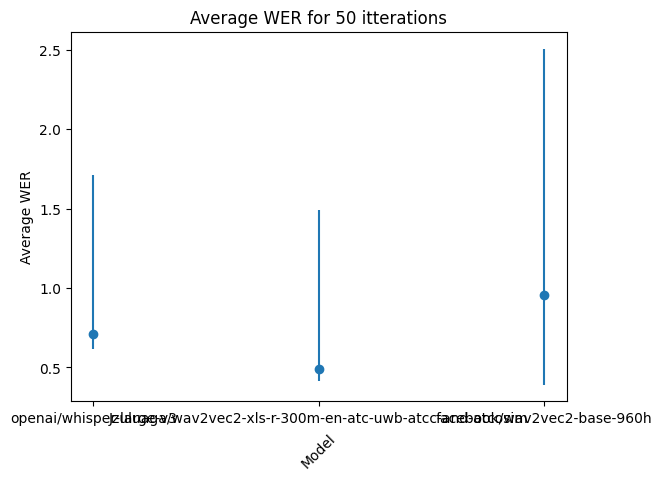

In [30]:
plt.errorbar(
    resultsDf['Model'],
    resultsDf['Average WER'],
    yerr=[resultsDf['Lowest WER'], resultsDf['Highest WER']],
    fmt='o'
)

plt.xlabel('Model')
plt.ylabel('Average WER')

plt.title('Average WER for 50 itterations')

plt.show()